# Example code for visualizing, results

## Setup

In [1]:
from glob import glob
import numpy as np
import scipy as sp
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

if os.path.split(os.getcwd())[-1] != 'structure-from-sound-python':
    os.chdir("../")

from src.detectors import gcc_phat_detector
from src.tdoa_matrix_to_tdoa_vector import tdoa_matrix_to_tdoa_vector
from src import tdoa_datasets_module

# import importlib
# importlib.reload(tdoa_datasets_module)


## Config

In [2]:
dataset_name = "tdoa_20201016"
experiment_name = "music_0015"

approx_room_size = 10  # meters

data_folder = os.path.join(".", "data", dataset_name, "data", experiment_name)
result_folder = os.path.join(
    ".", "results", dataset_name, "data", experiment_name)


## Detection comparision

Text(0, 0.5, 'distance difference (meters)')

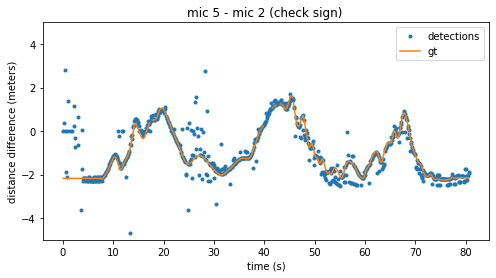

In [3]:
detections, tdoa_gt, detection_times = tdoa_datasets_module.get_detections_with_gt(
    data_folder, result_folder)
# speaker_gt_pos.shape

plt.figure(figsize=(8, 4))
mic1, mic2 = np.random.permutation(detections.shape[1])[:2]
# mic2 = 2


plt.plot(detection_times, detections[:, mic1, mic2], '.')
plt.plot(detection_times, tdoa_gt[:, mic1, mic2])
plt.title(f'mic {mic2} - mic {mic1} (check sign) ')
plt.legend(["detections", "gt"])
plt.ylim(-approx_room_size/2, approx_room_size/2)
plt.xlabel("time (s)")
plt.ylabel("distance difference (meters)")


Text(0.5, 0, 'detection residual (meters)')

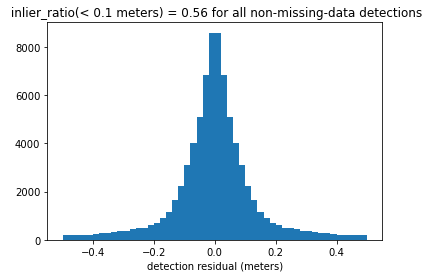

In [4]:
res = detections - tdoa_gt
res = res[np.logical_not(np.isnan(res))]
tol = 0.1

plt.hist(res[abs(res) < 0.5], 50)

plt.title(
    f' inlier_ratio(< {tol} meters) = {sum(abs(res) < tol)/np.size(res):.2f} for all non-missing-data detections')
plt.xlabel("detection residual (meters)")


## Tdoa-vector comparision

## Position-comparison

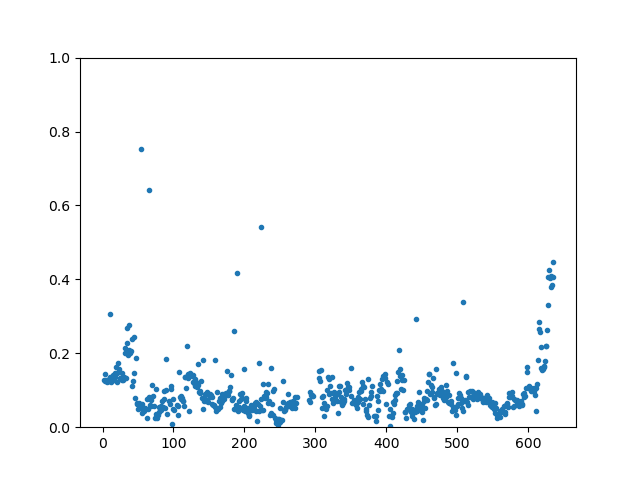

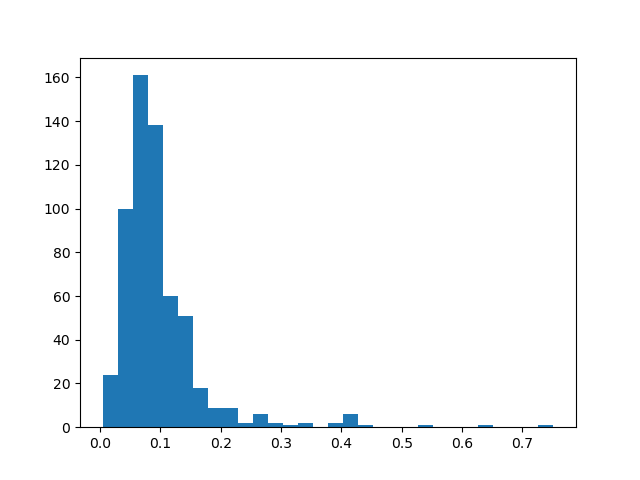

In [11]:
receiver_positions, sender_positions, receiver_gt_positions, sender_gt_positions = tdoa_datasets_module.get_positions_with_gt(
    data_folder, result_folder)


res = np.linalg.norm(sender_gt_positions - sender_positions, axis=1)

plt.figure()
plt.plot(res, '.')
plt.ylim(0, 1)

plt.figure()
plt.hist(res[res < 1], 30)


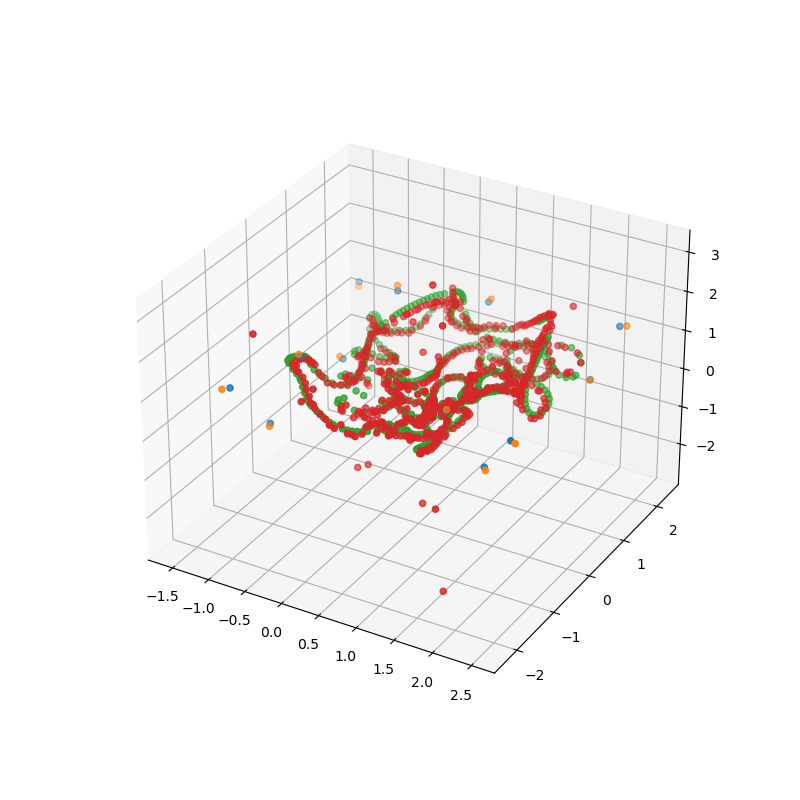

In [12]:
%matplotlib ipympl

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')


ax.scatter(receiver_positions[:, 0],
           receiver_positions[:, 1], receiver_positions[:, 2], 'r+')
ax.scatter(receiver_gt_positions[:, 0],
           receiver_gt_positions[:, 1], receiver_gt_positions[:, 2], 'bo')

ax.scatter(sender_gt_positions[:, 0], sender_gt_positions[:, 1],
           sender_gt_positions[:, 2], 'go')
reasonable_ind = np.all(np.logical_and(
    sender_positions < approx_room_size, sender_positions > -approx_room_size), axis=1)
ax.scatter(sender_positions[reasonable_ind, 0],
           sender_positions[reasonable_ind, 1], sender_positions[reasonable_ind, 2], 'go')
